In [17]:
import torch
import lmdb
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.models.image_restoration_model import ImageRestorationModel
from basicsr.utils.options import parse
import numpy as np
import cv2
import pickle
from tqdm.notebook import tqdm as log_progress
from collections import OrderedDict
from PIL import Image
import os
import torch
import numpy as np

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [21]:
finetuned_weight_path = '/home/gridsan/tye/NAFNet/experiments/FMD-SHG-08-29/models/net_g_20000.pth'
finetuned_model_weights = torch.load(finetuned_weight_path)

opt_path = './base_NAF/NAFNet-width64.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False

finetuned = create_model(opt)

finetuned = finetuned.net_g

finetuned.load_state_dict(finetuned_model_weights['params'])
print('finetuned weights loaded successfully')



 opt[network_g] =  OrderedDict([('type', 'NAFNet'), ('width', 64), ('enc_blk_nums', [2, 2, 4, 8]), ('middle_blk_num', 12), ('dec_blk_nums', [2, 2, 2, 2])])

img_channel =  5 



2023-08-30 15:00:18,562 INFO: Model [ImageRestorationModel] is created.


finetuned weights loaded successfully


In [25]:
count = 0 #Count goes from 0-6, change count based on what sample you want to visualize

a = './Visualization-8-24/' + str(count) + ':1_1_1_1_1_NOISY.pt'
b = './Visualization-8-24/' + str(count) + ':1_2_1_1_1_NOISY.pt'
c = './Visualization-8-24/' + str(count) + ':1_2_3_1_1_NOISY.pt'
d = './Visualization-8-24/' + str(count) + ':1_2_3_4_1_NOISY.pt'
e = './Visualization-8-24/' + str(count) + ':1_2_3_4_5_NOISY.pt'

gt_path = './Visualization-8-24/' + str(count) + ':1_1_1_1_1_GT.pt'
imgs = [a, b, c, d, e, gt_path]
uncertainties = []
predictions = []

lhat = 0.37185928225517273
with torch.no_grad():
    for i in log_progress(range(0, 5)):
        noisy = torch.load(imgs[i])
        in_img = noisy.unsqueeze(0) 
        in_img = in_img.to(device)
        out = finetuned(in_img.float())     
        img = out[0, 1, :, :]
        img = img.detach().cpu()
        img = img/torch.max(img)
        uncertainty = (out[0, 2, :, :] - out[0, 0, :, :]) * lhat

        uncertainties.append(uncertainty.detach().cpu().numpy())
        predictions.append(img.numpy())


FileNotFoundError: [Errno 2] No such file or directory: './Visualization-8-24/0:1_1_1_1_1_NOISY.pt'

In [16]:
images = [uncertainties[0], uncertainties[2], uncertainties[4]]
vmin = 0
vmax =  np.percentile(images[0], 95)
print('vmax = ', vmax)

for im in images:
    #im = np.mean(im, 0)
    count = 0
    for x in range(len(im)):
        for y in range(len(im)):
            if im[x][y] >= vmax:
                count += 1
    print('\nTop 5% Percentile Most Uncertain: ', count)

    print('Total Percentage: ', count/(512**2) * 100)
            

vmax =  0.05175377912819384

Top 5% Percentile Most Uncertain:  13108
Total Percentage:  5.00030517578125

Top 5% Percentile Most Uncertain:  4029
Total Percentage:  1.5369415283203125

Top 5% Percentile Most Uncertain:  2450
Total Percentage:  0.934600830078125


vmax =  0.05175377912819384
(512, 512)
(512, 512)
(512, 512)
(512, 512)


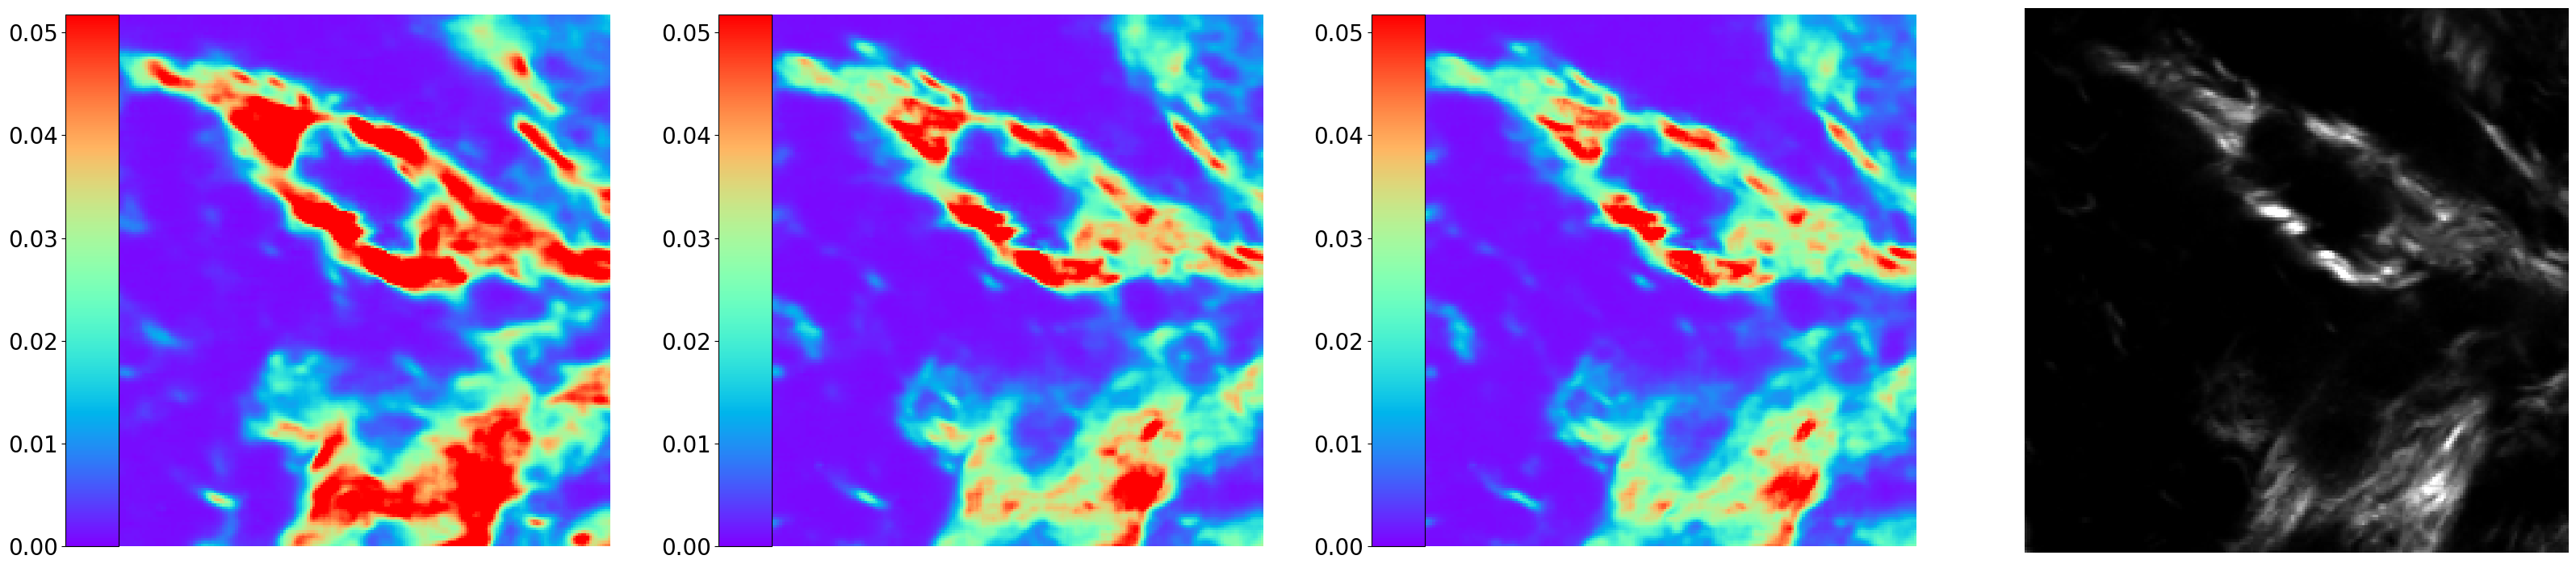

In [19]:
gt = torch.load(gt_path)
gt_img = torch.mean(gt, 0)
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(1, 4, figsize=(40, 10))  # Adjust figsize as needed

images = [uncertainties[0], uncertainties[2], uncertainties[4], gt_img]
vmin = 0
vmax =  np.percentile(images[0], 95)
print('vmax = ', vmax)
print(images[0].shape)

count = 0
for ax, image in zip(axes, images):
    divider = make_axes_locatable(ax)
    img = image


    if count == 3:
        im = ax.imshow(gt_img[50:250, 50:250], cmap='gray', vmin = 0, vmax = 0.5)  
        ax.axis('off')
        
    else:
        img = np.clip(img, 0, vmax)
        print(img.shape)
        im = ax.imshow(img[50:250, 50:250], cmap='rainbow', vmin=vmin, vmax=vmax)  
        cax = divider.append_axes('left', size='10%', pad= -0.5)
        colorbar = plt.colorbar(im, cax=cax, orientation='vertical')
        cax.yaxis.set_ticks_position('left')
        cax.tick_params(labelsize=20, direction = 'out') 
        ax.axis('off')
    count += 1
    
plt.show()